# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implementing ε-Greedy and UCB

In [2]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """
    def check_context(self, context, narms):
        if context is not None:
            assert isinstance(context, np.ndarray)
            assert np.issubdtype(context.dtype, np.floating)
            assert context.size % narms == 0
            
    def check_arm(self, arm):
        assert np.issubdtype(type(arm), np.integer) 
        assert arm <= self.narms and arm >= 1
        
    def check_reward(self, reward):
        assert np.issubdtype(type(reward), np.floating)
        
    def check_tround(self, tround):
        assert np.issubdtype(type(tround), np.integer) 
        assert tround > 0
        
    def check_narm(self, narms):
        assert np.issubdtype(type(narms), np.integer) 
        assert narms > 0
    
    def argmax_random(self, a):
        return np.random.choice(np.flatnonzero(a == a.max())) + 1

In [3]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability in interval [0.0, 1.0]

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        self.check_narm(narms)
        assert np.issubdtype(type(epsilon), np.floating) 
        assert epsilon >= 0 and epsilon <= 1
        assert np.issubdtype(type(Q0), np.floating)
        
        self.narms = narms
        self.epsilon = epsilon
        self.Q0 = Q0
        self.num_pulls = np.zeros(narms)
        self.mean_rewards = np.full(narms, Q0)
        
    def play(self, tround, context=None):
        self.check_tround(tround)
        self.check_context(context, self.narms)
        
        if np.random.binomial(1, self.epsilon):
            return np.random.randint(1, self.narms + 1)
        else:
            return self.argmax_random(self.mean_rewards)
        
    def update(self, arm, reward, context=None):
        self.check_arm(arm)
        self.check_reward(reward)        
        self.check_context(context, self.narms)
        
        arm_0 = arm - 1
        n = self.num_pulls[arm_0]
        if n > 0:
            self.mean_rewards[arm_0] = (self.mean_rewards[arm_0] * n + reward) / (n + 1)
        else:
            self.mean_rewards[arm_0] = reward
        self.num_pulls[arm_0] += 1

In [4]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        self.check_narm(narms)
        assert np.issubdtype(type(rho), np.floating) 
        assert rho > 0
        assert np.issubdtype(type(Q0), np.floating)
        
        self.narms = narms
        self.rho = rho
        self.Q0 = Q0
        self.num_pulls = np.zeros(narms)
        self.mean_rewards = np.full(narms, self.Q0)
    
    def play(self, tround, context=None):
        self.check_tround(tround)
        self.check_context(context, self.narms)
        
        Q_prev = np.copy(self.mean_rewards)
        if (tround > 1):
            pulled_prev = self.num_pulls > 0
            Q_prev[pulled_prev] += np.sqrt(self.rho * np.log(tround) / self.num_pulls[pulled_prev])
        return self.argmax_random(Q_prev)
        
    def update(self, arm, reward, context=None):
        self.check_arm(arm)
        self.check_reward(reward)        
        self.check_context(context, self.narms)
        
        arm_0 = arm - 1
        n = self.num_pulls[arm_0]
        if n > 0:
            self.mean_rewards[arm_0] = (self.mean_rewards[arm_0] * n + reward) / (n + 1)
        else:
            self.mean_rewards[arm_0] = reward
        self.num_pulls[arm_0] += 1

## 2. The Basic Thompson Bandit

In [5]:
class BetaThompson(MAB):
    """
    Beta-Bernoulli Thompson sampling multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    alpha0 : float, optional
        positive real prior hyperparameter

    beta0 : float, optional
        positive real prior hyperparameter
    """
    
    def __init__(self, narms, alpha0=1.0, beta0=1.0):
        self.check_narm(narms)
        assert np.issubdtype(type(alpha0), np.floating)
        assert alpha0 > 0
        assert np.issubdtype(type(beta0), np.floating) 
        assert beta0 > 0
        
        self.narms = narms
        self.alpha0 = np.ones(narms) * alpha0
        self.beta0 = np.ones(narms) * beta0
        self.sucess = np.zeros(narms)
        self.fail = np.zeros(narms)
        self.theta = np.zeros(narms)
    
    def play(self, tround, context=None):
        self.check_tround(tround)
        self.check_context(context, self.narms)
        
        for i in range(0, self.narms):
            self.theta[i] = np.random.beta(self.alpha0[i] + self.sucess[i], self.beta0[i] + self.fail[i])
        return self.argmax_random(self.theta)
        
        
    def update(self, arm, reward, context=None):
        self.check_arm(arm)
        self.check_reward(reward)        
        self.check_context(context, self.narms)
        
        arm_0 = arm - 1
        if (reward == 1):
            self.sucess[arm_0] += 1
        else:
            self.fail[arm_0] += 1
        

## 3. Off-Policy Evaluation

In [6]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    assert isinstance(mab, MAB)
    for arrayName in ['arms', 'rewards', 'contexts']:
        assert isinstance(eval(arrayName), np.ndarray)
    assert (np.issubdtype(type(nrounds), np.integer) and nrounds >= 0) or (nrounds is None)
    assert np.issubdtype(arms.dtype, np.integer)
    assert np.issubdtype(rewards.dtype, np.floating)
    assert np.issubdtype(contexts.dtype, np.floating)
    assert arms.ndim == 1
    assert rewards.ndim == 1
    assert contexts.ndim == 2
    assert arms.shape[0] == rewards.shape[0] == contexts.shape[0]
    assert contexts.shape[1] % mab.narms == 0
    assert arms.max() <= mab.narms and arms.min() >= 1
    
    matched_ctr = 0
    matched_rewards = list()
    for i in range(arms.size):
        if nrounds is not None and matched_ctr >= nrounds:
            break
        arm = mab.play(matched_ctr + 1, contexts[i])
        if arm == arms[i]:
            mab.update(arm, rewards[i], contexts[i])
            matched_ctr += 1
            matched_rewards.append(rewards[i])
    return np.array(matched_rewards)

In [7]:
def read_data(file_name='dataset.txt'):
    arms = []
    rewards = []
    contexts = []
    with open(file_name, 'r') as file:
        for line in file.readlines():
            tokens = line.strip().split()
            arms.append(tokens[0])
            rewards.append(tokens[1])
            contexts.append(tokens[2:])
    return (arms, rewards, contexts)

arms, rewards, contexts = read_data()

arms = np.array(arms).astype(int)
rewards = np.array(rewards).astype(float)
contexts = np.array(contexts).astype(float)

In [8]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.13125


In [9]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.16125


In [10]:
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('BetaThompson average reward', np.mean(results_BetaThompson))

BetaThompson average reward 0.20875


## 4. Contextual Bandits - LinUCB

In [11]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        self.check_narm(narms)
        assert np.issubdtype(type(ndims), np.integer) 
        assert ndims > 0
        assert np.issubdtype(type(alpha), np.floating) 
        assert alpha > 0
        
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha
        self.As = np.broadcast_to(np.eye(ndims), (narms, ndims, ndims)).copy()
        self.bs = np.zeros((narms, ndims))
        
    def play(self, tround, context):
        self.check_tround(tround)
        self.check_context(context, self.narms)
        
        context = np.reshape(context, newshape=(self.narms, -1))
        p_t = np.empty(self.narms)
        for i in range(self.narms):
            inv_a = inv(self.As[i])
            x = context[i]
            theta = inv_a @ self.bs[i]
            p_t[i] = theta.dot(x) + self.alpha * np.sqrt(x.dot(inv_a @ x))
        return self.argmax_random(p_t)
    
    def update(self, arm, reward, context):
        self.check_arm(arm)
        self.check_reward(reward)        
        self.check_context(context, self.narms)
        
        arm0 = arm - 1
        x = np.reshape(context, newshape=(self.narms, -1))[arm0]
        self.As[arm0] += np.outer(x, x)
        self.bs[arm0] += reward * x

In [12]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 5. Contextual Bandits - LinThompson

In [13]:
class LinThompson(MAB):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, v):
        self.check_narm(narms)
        assert np.issubdtype(type(ndims), np.integer) 
        assert ndims > 0
        assert np.issubdtype(type(v), np.floating) 
        assert v > 0
        
        self.narms = narms
        self.ndims = ndims
        
        self.b = np.broadcast_to(np.eye(ndims), (narms, ndims, ndims)).copy()
        self.mu_hat = np.zeros((narms, ndims))
        self.f = np.zeros((narms, ndims))
        
        self.v = v
        
    def play(self, tround, context):
        self.check_tround(tround)
        self.check_context(context, self.narms)
        
        context = np.reshape(context, newshape=(self.narms, -1))
        p_t = np.empty(self.narms)
        for i in range(self.narms):
            inv_b = inv(self.b[i])
            mu_wave = np.random.normal(self.mu_hat[i], np.abs(self.v * self.v * inv_b))[i]
            x = context[i]
            p_t[i] = x.dot(mu_wave)
        return self.argmax_random(p_t)
    
    def update(self, arm, reward, context):
        self.check_arm(arm)
        self.check_reward(reward)        
        self.check_context(context, self.narms)
        
        arm0 = arm - 1
        x = np.reshape(context, newshape=(self.narms, -1))[arm0]
        self.b[arm0] += np.outer(x, x)
        self.f[arm0] += x * reward
        self.mu_hat[arm0] = inv(self.b[arm0]) @ self.f[arm0]

In [14]:
mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

LinThompson average reward 0.435


## 6. Evaluation
### 6.A.

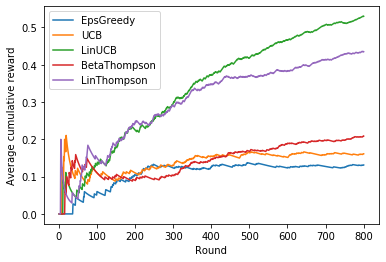

In [15]:
for mab_algorithm in ['EpsGreedy', 'UCB', 'LinUCB', 'BetaThompson', 'LinThompson']:
    results = eval('results_' + mab_algorithm)
    t_round = np.arange(1, results.size + 1)
    cumulative_reward_sum = np.cumsum(results)/t_round
    plt.plot(t_round, cumulative_reward_sum, label=mab_algorithm)
plt.legend()
plt.xlabel('Round')
plt.ylabel('Average cumulative reward')
plt.show()

### 6.B.

Best alpha is 0.1


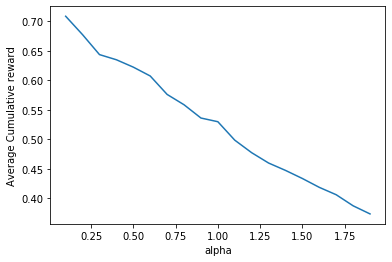

In [16]:
"""Looking for best Alpha"""

alpha_range = [i/10.0 for i in range(1,20)]
narms = 10
ndim = 10
samples = 3
nround = 800
mean = np.empty(len(alpha_range))
for i, alpha in enumerate(alpha_range):
    temp = 0
    for j in range(samples):
        mab = LinUCB(narms, ndim, alpha)
        temp += np.mean(offlineEvaluate(mab, arms, rewards, contexts, 800))
    mean[i] = temp / samples

print('Best alpha is ' + str(alpha_range[np.argmax(mean)]))

plt.plot(alpha_range, mean, label='LinUCB')
plt.xlabel('alpha')
plt.ylabel('Average Cumulative reward')
plt.show()


Best v is 1.2


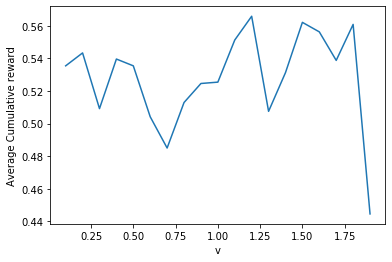

In [17]:
"""Looking for best v"""

v_range = [i/10.0 for i in range(1,20)]
narms = 10
ndim = 10
samples = 3
nround = 800
mean = np.empty(len(v_range))
for i, alpha in enumerate(v_range):
    temp = 0
    for j in range(samples):
        mab = LinThompson(narms, ndim, alpha)
        temp += np.mean(offlineEvaluate(mab, arms, rewards, contexts, nround))
    mean[i] = temp / samples

print('Best v is ' + str(alpha_range[np.argmax(mean)]))

plt.plot(alpha_range, mean, label='LinThompson')
plt.xlabel('v')
plt.ylabel('Average Cumulative reward')
plt.show()